==== DCF Valuation Output ====
Cost of Equity: 9.00%
WACC: 8.41%
PV of Forecasted FCFs: $522,366,032
PV of Terminal Value: $1,863,428,344
Enterprise Value (EV): $2,385,794,375
Equity Value: $2,085,794,375
Implied Share Price: $41.72


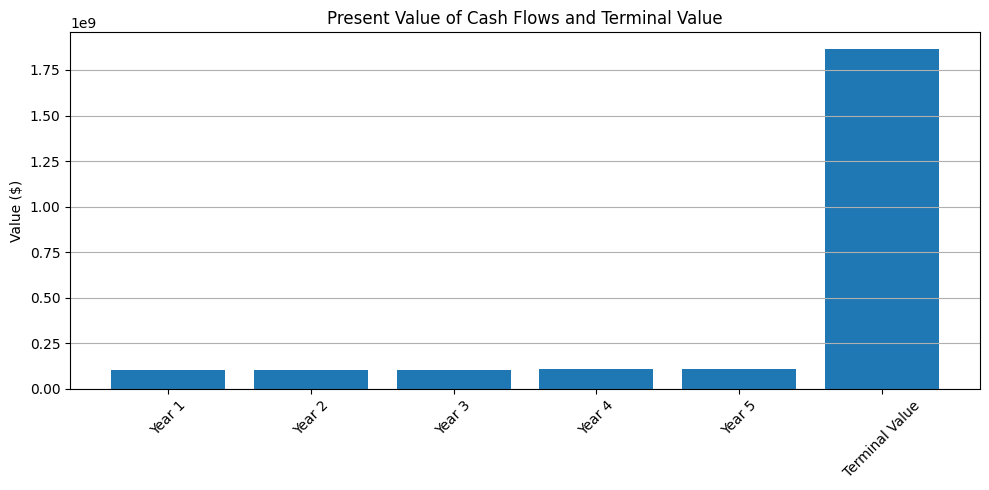

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- INPUTS ---
# These inputs can be later adapted to be read from a config file or CSV
inputs = {
    "risk_free_rate": 0.03,
    "beta": 1.2,
    "market_risk_premium": 0.05,
    "cost_of_debt": 0.055,
    "tax_rate": 0.21,
    "total_debt": 500_000_000,
    "cash_and_equivalents": 200_000_000,
    "shares_outstanding": 50_000_000,
    "FCF_0": 100_000_000,
    "g_exp": 0.10,
    "n": 5,
    "g_term": 0.025,
    "placeholder_share_price": 41.72  # Used for initial equity market value estimation
}

# --- VALIDATIONS ---
assert inputs["g_term"] < inputs["risk_free_rate"] + inputs["beta"] * inputs["market_risk_premium"], \
    "Terminal growth rate must be less than cost of equity"

assert inputs["shares_outstanding"] > 0, "Shares outstanding must be positive"

# --- FUNCTIONS ---

def calculate_cost_of_equity(rf, beta, market_risk_premium):
    return rf + beta * market_risk_premium

def calculate_wacc(cost_of_equity, cost_of_debt, tax_rate, equity_value, debt_value):
    total_value = equity_value + debt_value
    weight_equity = equity_value / total_value
    weight_debt = debt_value / total_value
    return weight_equity * cost_of_equity + weight_debt * cost_of_debt * (1 - tax_rate)

def forecast_fcfs(FCF_0, g_exp, n):
    return [FCF_0 * (1 + g_exp) ** t for t in range(1, n + 1)]

def calculate_terminal_value(FCF_n, g_term, WACC):
    return FCF_n * (1 + g_term) / (WACC - g_term)

def discount_cash_flows(cash_flows, WACC):
    return sum([cf / (1 + WACC) ** (t + 1) for t, cf in enumerate(cash_flows)])

def discount_terminal_value(TV, WACC, n):
    return TV / (1 + WACC) ** n

# --- MAIN CALCULATION ---

# Step 1: Calculate cost of equity
cost_of_equity = calculate_cost_of_equity(
    inputs["risk_free_rate"],
    inputs["beta"],
    inputs["market_risk_premium"]
)

# Step 2: Estimate market value of equity using placeholder price
market_value_equity = inputs["shares_outstanding"] * inputs["placeholder_share_price"]

# Step 3: Calculate net debt
net_debt = inputs["total_debt"] - inputs["cash_and_equivalents"]
net_debt = max(net_debt, 0)  # Ensure non-negative debt

# Step 4: Compute WACC
WACC = calculate_wacc(
    cost_of_equity,
    inputs["cost_of_debt"],
    inputs["tax_rate"],
    market_value_equity,
    net_debt
)

# Step 5: Forecast FCFs and compute terminal value
fcf_list = forecast_fcfs(inputs["FCF_0"], inputs["g_exp"], inputs["n"])
FCF_n = fcf_list[-1]
TV = calculate_terminal_value(FCF_n, inputs["g_term"], WACC)

# Step 6: Discount FCFs and terminal value
PV_FCF = discount_cash_flows(fcf_list, WACC)
PV_TV = discount_terminal_value(TV, WACC, inputs["n"])

# Step 7: Calculate Enterprise and Equity Value
EV = PV_FCF + PV_TV
equity_value = EV - net_debt
share_price = equity_value / inputs["shares_outstanding"]

# --- OUTPUT ---

print("==== DCF Valuation Output ====")
print(f"Cost of Equity: {cost_of_equity:.2%}")
print(f"WACC: {WACC:.2%}")
print(f"PV of Forecasted FCFs: ${PV_FCF:,.0f}")
print(f"PV of Terminal Value: ${PV_TV:,.0f}")
print(f"Enterprise Value (EV): ${EV:,.0f}")
print(f"Equity Value: ${equity_value:,.0f}")
print(f"Implied Share Price: ${share_price:,.2f}")

# --- OPTIONAL: Visualize Cash Flows and Terminal Value ---
years = [f"Year {i+1}" for i in range(inputs["n"])]
cash_flows_with_tv = fcf_list + [TV]
labels = years + ["Terminal Value"]
discounted_values = [cf / (1 + WACC) ** (i + 1) for i, cf in enumerate(fcf_list)] + [PV_TV]

plt.figure(figsize=(10, 5))
plt.bar(labels, discounted_values)
plt.title("Present Value of Cash Flows and Terminal Value")
plt.ylabel("Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


Monte Carlo Share Price Summary:
count    1000.000000
mean       43.897706
std        11.406243
min        19.471956
5%         28.367646
25%        35.720368
50%        42.981699
75%        50.092833
95%        63.663004
max       120.764455
Name: Share Price ($), dtype: float64


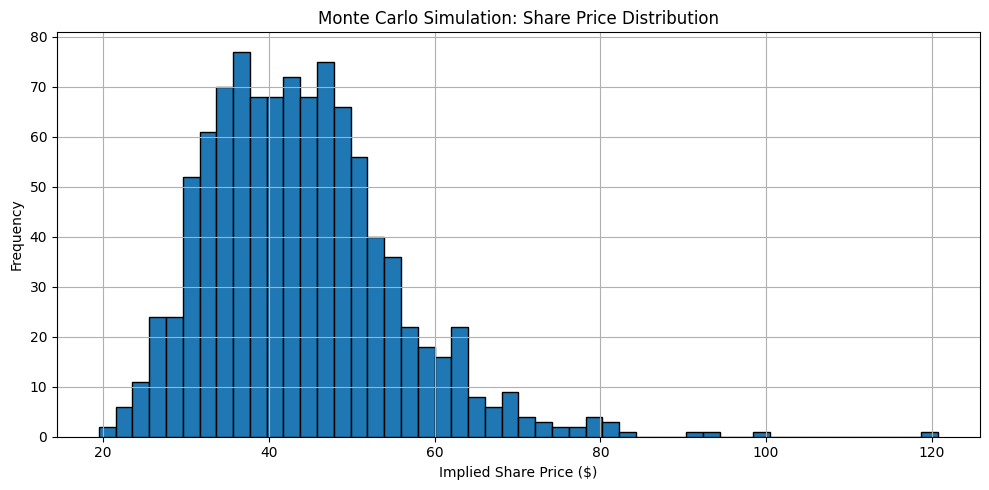

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CUSTOMIZABLE MONTE CARLO CONFIGURATION (Excel-style) ---

num_simulations = 1000

# Define assumptions: mean, std_dev, distribution_type
# Supported distributions: 'normal', 'lognormal', 'uniform', 'triangular'
monte_carlo_config = {
    "beta": {"mean": 1.2, "std": 0.2, "dist": "normal"},
    "g_exp": {"mean": 0.10, "std": 0.03, "dist": "normal"},
    "g_term": {"mean": 0.025, "std": 0.005, "dist": "truncated_normal"},  # GDP constraint
    "cost_of_debt": {"mean": 0.055, "std": 0.01, "dist": "normal"},
    "placeholder_share_price": {"mean": 41.72, "std": 3.0, "dist": "normal"}
}

# --- DISTRIBUTION SAMPLER ---
def sample_distribution(config):
    dist = config["dist"]
    mean = config["mean"]
    std = config["std"]

    if dist == "normal":
        return np.random.normal(mean, std)
    elif dist == "lognormal":
        sigma = np.sqrt(np.log(1 + (std / mean) ** 2))
        mu = np.log(mean) - 0.5 * sigma ** 2
        return np.random.lognormal(mu, sigma)
    elif dist == "uniform":
        return np.random.uniform(mean - std, mean + std)
    elif dist == "triangular":
        return np.random.triangular(mean - std, mean, mean + std)
    elif dist == "truncated_normal":
        while True:
            x = np.random.normal(mean, std)
            if x > 0 and x < 0.05:  # assume terminal growth capped at 5%
                return x
    else:
        raise ValueError(f"Unsupported distribution: {dist}")

# --- STORAGE FOR RESULTS ---
results = []

# --- SIMULATION LOOP ---
for _ in range(num_simulations):
    # Sample each input
    beta_sim = sample_distribution(monte_carlo_config["beta"])
    g_exp_sim = sample_distribution(monte_carlo_config["g_exp"])
    g_term_sim = sample_distribution(monte_carlo_config["g_term"])
    cost_of_debt_sim = sample_distribution(monte_carlo_config["cost_of_debt"])
    placeholder_price_sim = sample_distribution(monte_carlo_config["placeholder_share_price"])

    # Sanity checks
    if beta_sim < 0 or g_exp_sim < 0 or placeholder_price_sim <= 0:
        continue

    cost_of_equity_sim = calculate_cost_of_equity(
        inputs["risk_free_rate"], beta_sim, inputs["market_risk_premium"]
    )

    # Enforce g_term < cost_of_equity
    if g_term_sim >= cost_of_equity_sim:
        continue

    market_value_equity_sim = inputs["shares_outstanding"] * placeholder_price_sim
    WACC_sim = calculate_wacc(
        cost_of_equity_sim,
        cost_of_debt_sim,
        inputs["tax_rate"],
        market_value_equity_sim,
        net_debt
    )

    fcf_list_sim = forecast_fcfs(inputs["FCF_0"], g_exp_sim, inputs["n"])
    FCF_n_sim = fcf_list_sim[-1]
    TV_sim = calculate_terminal_value(FCF_n_sim, g_term_sim, WACC_sim)
    PV_FCF_sim = discount_cash_flows(fcf_list_sim, WACC_sim)
    PV_TV_sim = discount_terminal_value(TV_sim, WACC_sim, inputs["n"])

    EV_sim = PV_FCF_sim + PV_TV_sim
    equity_value_sim = EV_sim - net_debt
    share_price_sim = equity_value_sim / inputs["shares_outstanding"]

    results.append({
        "Beta": beta_sim,
        "g_exp": g_exp_sim,
        "g_term": g_term_sim,
        "Cost of Debt": cost_of_debt_sim,
        "WACC": WACC_sim,
        "EV ($B)": EV_sim / 1e9,
        "Equity ($B)": equity_value_sim / 1e9,
        "Share Price ($)": share_price_sim
    })

# --- OUTPUT RESULTS ---

df_results = pd.DataFrame(results)
summary_stats = df_results.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

print("Monte Carlo Share Price Summary:")
print(summary_stats["Share Price ($)"])

# --- PLOT RESULTS ---
plt.figure(figsize=(10, 5))
plt.hist(df_results["Share Price ($)"], bins=50, edgecolor='black')
plt.title("Monte Carlo Simulation: Share Price Distribution")
plt.xlabel("Implied Share Price ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
